In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

Dropdown(description='State:', options=([1.0, 39.999984678222155, 116.32721940798194], [6.0, 40.00733255243137…

Selected State, Latitude and Longitude: 37.0,40.009712581691055,116.31515504515379


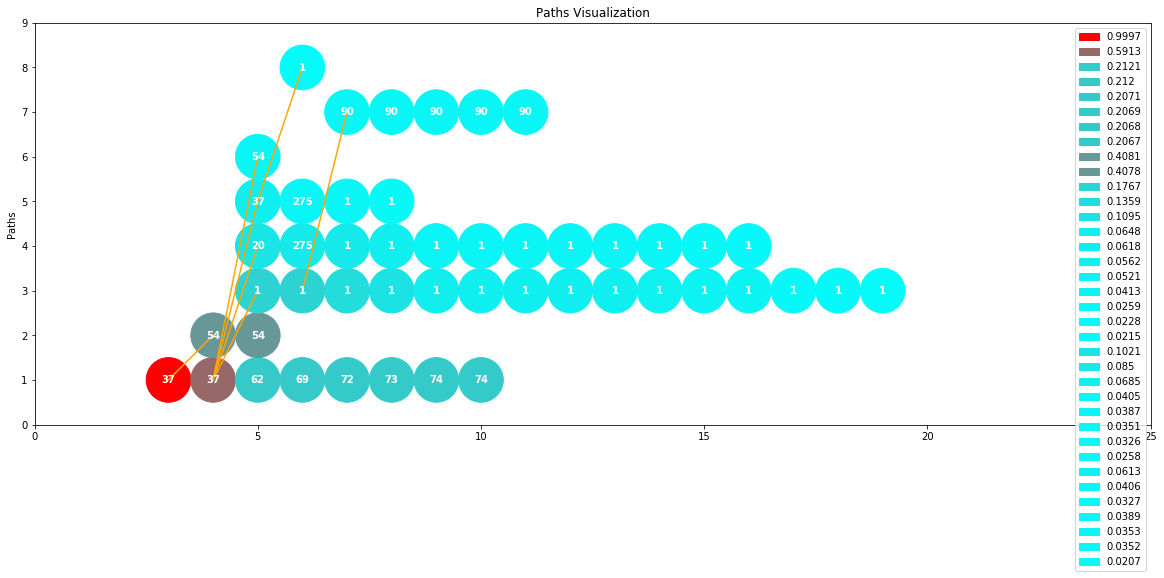

In [6]:
#predicted paths with probabilities
import ipywidgets as widgets
import seaborn as sns
import pandas as pd
import math
import warnings
from queue import PriorityQueue
import matplotlib.pyplot as plt
from matplotlib.patches import Circle 
warnings.filterwarnings('ignore')

pd.options.mode.chained_assignment = None

def path_vis():
    global path

    path = path.sort_values(['PathId', 'Hour', 'Prob'])
    path = path.reset_index(drop=True)
    # create a new graph where we will later add rectangles for each hour:cluster
    fig2 = plt.figure(figsize=(20, 20))
    ax1 = fig2.add_subplot(111, aspect='equal')

    limsx = (0, 25)
    limsy = (0, path['PathId'].nunique()+1)

    path_counter = 1
    prev_path = path.loc[0, 'PathId']

    for i in range(0, len(path)):
        if prev_path!= path.loc[i, 'PathId']:
            prev_path = path.loc[i, 'PathId']
            path_counter = path_counter + 1

            #look for parent and draw the connection
            for j in range(0, i):
                if (path.loc[j, 'StateId'] == path.loc[i, 'FromState'] and
                        path.loc[j, 'Hour'] == path.loc[i, 'FromHour'] and
                            path.loc[j, 'Prob'] == path.loc[i, 'FromProb']):
                        #import pdb; pdb.set_trace()
                        p_path_id = path.loc[j, 'PathId']
                        p_hour = path.loc[j, 'Hour']
                        c_path_id = path.loc[i, 'PathId']
                        c_hour = path.loc[i, 'Hour']
                        ax1.plot([p_hour,c_hour],[p_path_id,c_path_id],'-', color = 'orange')
                        break

        x = path.loc[i, 'Hour']
        y = path_counter
        circ = Circle((x, y), radius=0.5, color=(path.loc[i, 'Prob'], 1-path.loc[i, 'Prob'], 1-path.loc[i, 'Prob']), label=round(path['Prob'][i], 4))
        ax1.add_patch(circ)
        ax1.annotate(str(int(path.loc[i, 'StateId'])), (x, y),
                                 color='w', weight='bold', fontsize=10, ha='center', va='center')

    handles, labels = ax1.get_legend_handles_labels()
    handle_list, label_list = [], []
    for handle, label in zip(handles, labels):
        if label not in label_list:
            handle_list.append(handle)
            label_list.append(label)
    plt.legend(handle_list, label_list)

    plt.ylabel('Paths')
    plt.title('Paths Visualization')
    plt.xlim(limsx)
    plt.ylim(limsy)
    plt.show()

def meters(lat1, lon1, lat2, lon2):
    R = 6378.137  # Radius of earth in KM
    dLat = lat2 * math.pi / 180 - lat1 * math.pi / 180
    dLon = lon2 * math.pi / 180 - lon1 * math.pi / 180
    a = math.sin(dLat / 2) * math.sin(dLat / 2) + math.cos(lat1 * math.pi / 180) * math.cos(
        lat2 * math.pi / 180) * math.sin(dLon / 2) * math.sin(dLon / 2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = R * c
    return d * 1000  # meters


def add_in_queue(prob, states, hour, from_state, from_hour, from_prob):
    global q

    size = prob.size
    for i in range(0, size):
        q.put((1 - prob[0][i], states[i], prob[0][i], hour, from_state, from_hour, from_prob))


def ent(data):
    entropy = 0
    size = data.size
    for i in range(0, size):
        entropy = entropy + (- data[0][i] * math.log(data[0][i], 2))
    return entropy


def print_q():
    while not q.empty():
        next_item = q.get()
        print(next_item)


def assign_paths():
    global path

    path.loc[0, 'PathId'] = 1
    
    for i in range(1, len(path)):
        #continuation of a path
        if ((path.loc[i, 'Hour'] == path.loc[i-1, 'Hour'] + 1) and
            (path.loc[i, 'FromState'] == path.loc[i-1, 'StateId']) and
                (path.loc[i, 'FromHour'] == path.loc[i-1, 'Hour']) and
                (path.loc[i, 'FromProb'] == path.loc[i-1, 'Prob'])):
            path.loc[i, 'PathId'] = path.loc[i - 1, 'PathId']
        #new path
        else:
            path_id = 0
            row_count = 0
            sim_path_count = 0
            #look for parent     
            for j in range(0, i):
                row_count = row_count + 1
                if (path.loc[j, 'StateId'] == path.loc[i, 'FromState'] and
                    path.loc[j, 'Hour'] == path.loc[i, 'FromHour'] and
                        path.loc[j, 'Prob'] == path.loc[i, 'FromProb']):
                    path_id = path.loc[j, 'PathId']
                    break
            for j in range(0, i):
                if(path.loc[j, 'FromState'] == path.loc[i, 'FromState'] and
                    path.loc[j, 'FromHour'] == path.loc[i, 'FromHour'] and
                        path.loc[j, 'FromProb'] == path.loc[i, 'FromProb']):
                    path_id = 0
                    
            if path_id != 0:
                #if it is still continuation of an old path
                if path.loc[row_count-1, 'PathId'] != path.loc[row_count, 'PathId']:
                    path.loc[i, 'PathId'] = path_id
                #new path with existing tail from parent
                else:
                    new_path_id = path['PathId'].max() + 1
                    path.loc[i, 'PathId'] = new_path_id
            else:
                new_path_id = path['PathId'].max() + 1
                path.loc[i, 'PathId'] = new_path_id 
            
    path_vis()
    
def path_conf(lat, lon):
    global path
    
    tot_states = trained_model_df['StateId'].nunique()
    state_list = trained_model_df['StateId'].unique()
    path_row = 0

    if hour == 23:
        nxt_hour = 0
    else:
        nxt_hour = hour + 1

    for i in range(0, len(trained_model_df)):

        trn_lat = trained_model_df['AvgLat'][i]
        trn_lon = trained_model_df['AvgLon'][i]
        act_state = trained_model_df['StateId'][i]

        if meters(trn_lat, trn_lon, lat, lon) <= d_thrhld:

            from_col_no = tot_states * nxt_hour + 5
            to_col_no = from_col_no + tot_states
            predic_list = trained_model_df.iloc[i:i + 1, from_col_no:to_col_no].as_matrix()
            add_in_queue(predic_list, state_list, nxt_hour, "start", hour, 1)

            while not q.empty():
                next_item = q.get()
                if next_item[2] > confidence_thrshld:
                    read_hour = next_item[3]
                    next_row = trained_model_df.loc[trained_model_df['StateId'] == (next_item[1])]

                    if read_hour == 23:
                        next_hour = 0
                    else:
                        next_hour = read_hour + 1
                        
                    from_col_no = tot_states * next_hour + 5
                    to_col_no = from_col_no + tot_states
                    next_list = next_row.iloc[0:1, from_col_no:to_col_no].as_matrix()
                    next_list = next_list * next_item[2]
                    from_hour = next_item[3]
                    from_state = next_item[1]
                    from_prob = next_item[2]

                    path.loc[path_row, 'StateId'] = next_item[1]
                    path.loc[path_row, 'Prob'] = next_item[2]
                    path.loc[path_row, 'Hour'] = next_item[3]
                    path.loc[path_row, 'FromState'] = next_item[4]
                    path.loc[path_row, 'FromHour'] = next_item[5]
                    path.loc[path_row, 'FromProb'] = next_item[6]
                    path_row = path_row + 1

                    add_in_queue(next_list, state_list, read_hour+1, from_state, from_hour, from_prob)
            
            if not path.empty:
                assign_paths()
                path = path.iloc[0:0]
                #print(path_df)
            else:
                path = path.iloc[0:0]
                print("No paths with this confidence threshold found.")
            break
def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        lat = change['new'][1]
        lon = change['new'][2]
        
        print ("Selected State, Latitude and Longitude: " + str(change['new'][0]) + "," + str(lat) + "," + str(lon))
        path_conf(lat, lon)

# -------------------------------------------------------------------------------------------------------
user = "000"
src_path = "C:/Users/12sha/Documents/thesislocation/code_/stay points/v0.6 results"
confidence_thrshld = 0.02 #minimum confidence for path predictions
month = "200904" #model to be used for path predictions
d_thrhld = 10
hour = 2

q = PriorityQueue()
path = pd.DataFrame()

path['StateId'] = 0
path['Hour'] = 0
path['Prob'] = 0
path['FromState'] = 0
path['FromHour'] = 0
path['FromProb'] = 0

trained_model_file = src_path + "/User " + user + "/" + month + "/markovchains/final.csv"
file1 = src_path + "/User " + user + "/" + month + "/path_df.csv"
file2 = src_path + "/User " + user + "/" + month + "/path.csv"

trained_model_df = pd.read_csv(trained_model_file, header=0)

dfList = trained_model_df[['StateId', 'AvgLat', 'AvgLon']].values
dfList = dfList.tolist()

w1 = widgets.Dropdown(
    options=dfList,
    description='State:',
)

display(w1)        
w1.observe(on_change)